In [1]:
import pandas as pd
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdCoordGen
import pandas as pd
import numpy as np
from itertools import product, permutations, combinations
import sys
import os

# Assuming 'cyclpept-ML-models' is in the same directory as your script
# Get the absolute path to the 'cyclpept-ML-models' directory
path_to_cyclpept_ml = os.path.abspath('cyclpept-ML-models')

# Add this path to the sys.path list
sys.path.append(path_to_cyclpept_ml)

from models.apply_model import make_predictions

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependen

In [2]:
def filter_for_non_polar_AA(df):
    return df.loc[df['Type of side chaind'] != 'Polar']
def price_filter(df, price_limit):
    return df.loc[df['Cheapest Price (EUR/g)'] <= price_limit]

In [3]:

def backbone_diversity(set_df):
    unique_backbones = set_df['Backbonec'].unique()
    return len(unique_backbones)

def side_chain_diversity(set_df):
    unique_side_chains = set_df['Type of side chaind'].unique()
    return len(unique_side_chains)

def calculate_diversity_score(set_df):
    backbone_score = backbone_diversity(set_df)
    side_chain_score = side_chain_diversity(set_df)
    return (backbone_score + side_chain_score) / 2

def generate_diverse_sets(df, num_sets=10, set_size=31, num_trials=1000):
    """
    Generate diverse sets of amino acids from the dataframe.

    Parameters:
    - df: DataFrame containing amino acid data.
    - num_sets: Number of diverse sets to generate.
    - set_size: Number of amino acids in each set.
    - num_trials: Number of random trials to perform in search for diverse sets.

    Returns:
    - A list of dataframes, each representing a diverse set of amino acids.
    """
    top_sets = []
    top_scores = []

    for _ in range(num_trials):
        sample_df = df.sample(n=set_size)
        diversity_score = calculate_diversity_score(sample_df)
        
        if len(top_scores) < num_sets:
            top_sets.append(sample_df)
            top_scores.append(diversity_score)
        else:
            min_score = min(top_scores)
            if diversity_score > min_score:
                min_index = top_scores.index(min_score)
                top_sets[min_index] = sample_df
                top_scores[min_index] = diversity_score

    return top_sets, top_scores

# Generate the sets


# # Example output
# print("Diversity Scores of the Top Sets:", top_scores)


def generate_name_permutations(df, min_names, max_names, allow_repetitions=True):
    all_permutations_set = set()
    
    unique_names = df['Name'].unique()  # Ensure unique names are used
    print(f"Unique Names Count: {len(unique_names)}")  # Debug: Print unique names count
    
    for r in range(min_names, max_names + 1):
        if allow_repetitions:
            combination_generator = product(unique_names, repeat=r)
        else:
            if len(unique_names) < r:
                print(f"Cannot generate permutations of length {r} without repetitions from {len(unique_names)} unique names.")
                continue  # Skip to next iteration if not enough unique names
            combination_generator = combinations(unique_names, r)
        
        for combination in combination_generator:
            for perm in permutations(combination):
                all_permutations_set.add(' '.join(perm))
    
    return list(all_permutations_set)

def create_dict(df):
    df.reset_index(drop=True, inplace=True)
    bbdict = {}
    for idx, aa in enumerate(df['Name']):
        bbdict[aa] = df['SMILES'][idx]

    bbdict['res2'] = 'SCCCNC(OCC1C(C=CC=C2)=C2C3=C1C=CC=C3)=O'
    bbdict['mpa'] = 'O=C(O)CCS'
    bbdict['linker1'] = 'O=C(CCl)CCl'

    return bbdict

def final_sequence(aa_sequence):    
    final_sequence = 'mpa'+' '+ aa_sequence+ ' ' + 'res2'
    return final_sequence





# Building linear peptides

In [4]:
# def build_peptide(sequence, bbdict):

#     #print('this is the sequence: ' + str(sequence))

#     sequence = sequence.split(' ')
#     sequence.reverse()

#     #fmoc coupling
#     rxn = AllChem.ReactionFromSmarts('([#8]=[#6](-[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')

#     reacts = (Chem.MolFromSmiles(bbdict[sequence[0]]), Chem.MolFromSmiles(bbdict[sequence[1]]))

#     products = rxn.RunReactants(reacts)

#     product = products[0][0]

#     if len(sequence) == 2:
#         return Chem.MolToSmiles(product)
#     else:
#         for aa in sequence[2:]:
#             try:
#                 reactant_smiles = bbdict[aa]
#             except KeyError:
#                 print(f"KeyError: '{aa}' not found in dictionary.")
#                 break  # or continue with a default value or handling

#             reactant_mol = Chem.MolFromSmiles(reactant_smiles)
#             reacts = (product, reactant_mol)
#             products = rxn.RunReactants(reacts)
#             print(products)
#             if products:  # Check if products were generated
#                 product = products[0][0]
#             else:
#                 print(f"KeyError:There is an issue with {aa}")
#                 break  # or continue with a default value or handling



#         #Remove protecting groups
            
#         #remove nboc
#         nboc = 'CC(C)(C)OC(NC)=O'
#         if product.HasSubstructMatch(Chem.MolFromSmiles(nboc)):
#             # print('nboc removal')
#             # display(product)
#             rxn = AllChem.ReactionFromSmarts('([#6]-[#6](-[#6])(-[#6])-[#8]-[#6](-[#7:1]-[#6:2])=[#8])>>[#7:1]-[#6:2]')
#             reacts = (product,)
#             products = rxn.RunReactants(reacts)
#             product = products[0][0]

#         mol = product

#         #remove tbu
#         tbu = 'COC(C)(C)C'

#         pgs = [tbu]
#         pgrepl = ['CO']

#         for idx, pg in enumerate(pgs):
#             mol = Chem.rdmolops.ReplaceSubstructs(mol, Chem.MolFromSmiles(pg), Chem.MolFromSmiles(pgrepl[idx]))
#             mol = mol[0]

#         #remove pbf, trt
#         pbf = 'CC1(C)Cc2c(C)c(S(=O)=O)c(C)c(C)c2O1'
#         trt = 'C(c1ccccc1)(c2ccccc2)c3ccccc3'

#         pgs = [pbf, trt]

#         for idx, pg in enumerate(pgs):
#             mol = Chem.rdmolops.DeleteSubstructs(mol, Chem.MolFromSmiles(pg))
#             # print(pg)
#             # display(mol)

#         smile = Chem.MolToSmiles(mol, kekuleSmiles = True)
#         product = Chem.MolFromSmiles(smile)
        
#         #fmoc removal if neccessary
#         product = rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles('O=COCC1C2=C(C=CC=C2)C3=C1C=CC=C3'))

#         #display(product)

#         return product


In [5]:
def initialize_reaction(sequence):
    sequence = sequence.split(' ')
    sequence.reverse()
    return sequence, AllChem.ReactionFromSmarts('([#8]=[#6](-[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')


In [6]:
def perform_initial_coupling(sequence, bbdict, rxn):
    reacts = (Chem.MolFromSmiles(bbdict[sequence[0]]), Chem.MolFromSmiles(bbdict[sequence[1]]))
    products = rxn.RunReactants(reacts)
    return products[0][0]  # Assuming the reaction always succeeds and takes the first product


In [7]:
def extend_peptide_chain(sequence, product, bbdict, rxn):
    for aa in sequence[2:]:
        try:
            reactant_smiles = bbdict[aa]
            reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        except KeyError:
            print(f"KeyError: '{aa}' not found in dictionary.")
            break  # Adjust based on desired error handling

        reacts = (product, reactant_mol)
        products = rxn.RunReactants(reacts)
        if products:
            product = products[0][0]  # Assuming successful reaction
        else:
            #print(f"Error: There is an issue with {aa}")
            try:
                rxn2 = AllChem.ReactionFromSmarts('([#8]-[#6](=[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')
                products = rxn2.RunReactants(reacts)
                product = products[0][0]
            except:
                print(f"Error: There is an issue with {aa}")
                break  # Adjust based on desired error handling
    return product


In [8]:
def remove_protecting_groups(product):
    # Remove nboc
    nboc_smarts = 'CC(C)(C)OC(NC)=O'
    if product.HasSubstructMatch(Chem.MolFromSmiles(nboc_smarts)):
        rxn_nboc = AllChem.ReactionFromSmarts('([#6]-[#6](-[#6])(-[#6])-[#8]-[#6](-[#7:1]-[#6:2])=[#8])>>[#7:1]-[#6:2]')
        product = rxn_nboc.RunReactants((product,))[0][0]

    # Replace substructures for tbu
    tbu_smarts = 'COC(C)(C)C'
    tbu_replacement = 'CO'
    product = Chem.rdmolops.ReplaceSubstructs(product, Chem.MolFromSmiles(tbu_smarts), Chem.MolFromSmiles(tbu_replacement))[0]

    # Delete substructures for pbf and trt
    for pg_smarts in ['CC1(C)Cc2c(C)c(S(=O)=O)c(C)c(C)c2O1', 'C(c1ccccc1)(c2ccccc2)c3ccccc3']:
        product = Chem.rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles(pg_smarts))

    # FMOC removal (if necessary)
    fmoc_smarts = 'O=COCC1C2=C(C=CC=C2)C3=C1C=CC=C3'
    product = Chem.rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles(fmoc_smarts))

    return product


In [9]:
def build_peptide(sequence, bbdict):
    sequence, rxn = initialize_reaction(sequence)
    product = perform_initial_coupling(sequence, bbdict, rxn)
    if len(sequence) > 2:
        product = extend_peptide_chain(sequence, product, bbdict, rxn)
    product = remove_protecting_groups(product)
    return product
#Chem.MolToSmiles(product, kekuleSmiles=True)


In [10]:
def disulfide_cyc(linear_peptide):
    
    oxrxn = AllChem.ReactionFromSmarts('([#16:1].[#16:2])>>[#16:1]-[#16:2]')
    reacts = (linear_peptide,)
    try:
        products = oxrxn.RunReactants(reacts) # tuple

        product = products[0][0]
        
        rdCoordGen.AddCoords(product) #makes mc look nicer
    except:
        print('Fuckup!')

    #display(product)

    return product

In [11]:
def linker_cyc(linear_peptide, linker):
    
    cycrxn = AllChem.ReactionFromSmarts('([#16:1]-[#6:2].[#16:3]-[#6:4]).([#6:5]-[#17].[#6:6]-[#17])>>([#6:2]-[#16:1]-[#6:5].[#6:4]-[#16:3]-[#6:6])')
    reacts = (linear_peptide, linker)
    try:
        products = cycrxn.RunReactants(reacts) # tuple
        product = products[0][0]
        rdCoordGen.AddCoords(product)
    except:
        print('Quel dommage!')

    #display(product) 
        
    return product

## Test of the function on one sequence

In [12]:
def generation_aa_library(price_limit,num_sets, num_aa):
    df = pd.read_csv('Updated_SI_Table_with_SMILES_HBD.csv')
    df['Name'] = df['Name'].str.replace(' ', '_', regex=False)
    test = filter_for_non_polar_AA(df)
    test = price_filter(test, price_limit)
    top_sets, top_scores = generate_diverse_sets(test, num_sets=num_sets, set_size=num_aa, num_trials=2000)
    return top_sets, top_scores

In [13]:
def generate_cyclic_peptide_set(top_set, min_len, max_len, repetition, type_of_cyclization):
    bbdict = create_dict(top_set)
    linker = Chem.MolFromSmiles(bbdict['linker1'])
    list_structures = []
    list_combinations = generate_name_permutations(top_set, min_len, max_len, allow_repetitions=repetition)
    for combination in list_combinations:
        sequence = final_sequence(combination)
        linear_peptide = build_peptide(sequence, bbdict)
        if type_of_cyclization == 'disulfide':
            product = disulfide_cyc(linear_peptide)
        else:
            product = linker_cyc(linear_peptide, linker)
        list_structures.append(product)
    return list_structures

In [14]:
def to_smiles(list_of_mols):
    smiles_list = []
    for mol in list_of_mols:
        smiles_list.append(Chem.MolToSmiles(mol))
    return smiles_list


In [15]:
def generate_permeability_df(list_structures):
    smiles_list = to_smiles(list_structures)
    
    permeability = make_predictions(smiles_list)
    
    if isinstance(permeability, np.ndarray):
        permeability = permeability.tolist()

    df = pd.DataFrame({
        'Mol': list_structures,
        'SMILES': smiles_list,
        'Permeability': permeability
    })
    
    return df

In [16]:
def calculate_df_metrics(df,threshold=-6):
    
    mean_permeability=df['Permeability'].mean()
    max_permeability=df['Permeability'].max()
    count_high_permeability = df['Permeability'].ge(threshold).sum()
    permeability_percentage = (count_high_permeability / len(df))

    return mean_permeability, max_permeability, permeability_percentage


In [17]:
def return_best_structures(df, top_n):
    sorted_df = df.sort_values(by='Permeability', ascending=False)
    
    # Get the top 'n' values from the 'SMILES' column
    top_smiles = sorted_df['SMILES'].head(top_n).tolist()
    top_mols = sorted_df['Mol'].head(top_n).tolist()
    for top_mol in top_mols:
        display(top_mol)
    return top_smiles

In [18]:
top_sets, top_scores = generation_aa_library(price_limit=100, num_sets=5, num_aa=10)

lists_of_peptides_lists = []
for top_set in top_sets:
    test_list = generate_cyclic_peptide_set(top_set, 3, 3, False, 'linker')
    lists_of_peptides_lists.append(test_list)

list_of_dfs = []
for list_of_peptides_lists in lists_of_peptides_lists:
    list_of_dfs.append(generate_permeability_df(list_of_peptides_lists))

mean = []
max = []
percentage = []
for dataframe in list_of_dfs:
    mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(dataframe)
    mean.append(mean_permeability)
    max.append(max_permeability)
    percentage.append(permeability_percentage)
    return_best_structures(dataframe, top_n=1, show=True) 

Unique Names Count: 10
Unique Names Count: 10
Unique Names Count: 10
Unique Names Count: 10
Unique Names Count: 10


/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estim

TypeError: return_best_structures() got an unexpected keyword argument 'show'

# Test

In [3]:
import pandas as pd
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdCoordGen
import pandas as pd
import numpy as np
from itertools import product, permutations, combinations
import sys
import os

# Assuming 'cyclpept-ML-models' is in the same directory as your script
# Get the absolute path to the 'cyclpept-ML-models' directory
path_to_cyclpept_ml = os.path.abspath('cyclpept-ML-models')

# Add this path to the sys.path list
sys.path.append(path_to_cyclpept_ml)

from models.apply_model import make_predictions

def filter_for_non_polar_AA(df):
    return df.loc[df['Type of side chaind'] != 'Polar']
def price_filter(df, price_limit):
    return df.loc[df['Cheapest Price (EUR/g)'] <= price_limit]


def backbone_diversity(set_df):
    unique_backbones = set_df['Backbonec'].unique()
    return len(unique_backbones)

def side_chain_diversity(set_df):
    unique_side_chains = set_df['Type of side chaind'].unique()
    return len(unique_side_chains)

def calculate_diversity_score(set_df):
    backbone_score = backbone_diversity(set_df)
    side_chain_score = side_chain_diversity(set_df)
    return (backbone_score + side_chain_score) / 2

def generate_diverse_sets(df, num_sets=10, set_size=31, num_trials=1000):
    """
    Generate diverse sets of amino acids from the dataframe.

    Parameters:
    - df: DataFrame containing amino acid data.
    - num_sets: Number of diverse sets to generate.
    - set_size: Number of amino acids in each set.
    - num_trials: Number of random trials to perform in search for diverse sets.

    Returns:
    - A list of dataframes, each representing a diverse set of amino acids.
    """
    top_sets = []
    top_scores = []

    for _ in range(num_trials):
        sample_df = df.sample(n=set_size)
        diversity_score = calculate_diversity_score(sample_df)
        
        if len(top_scores) < num_sets:
            top_sets.append(sample_df)
            top_scores.append(diversity_score)
        else:
            min_score = min(top_scores)
            if diversity_score > min_score:
                min_index = top_scores.index(min_score)
                top_sets[min_index] = sample_df
                top_scores[min_index] = diversity_score

    return top_sets, top_scores

# Generate the sets


# # Example output
# print("Diversity Scores of the Top Sets:", top_scores)


def generate_name_permutations(df, min_names, max_names, allow_repetitions=True):
    all_permutations_set = set()
    
    unique_names = df['Name'].unique()  # Ensure unique names are used
    print(f"Unique Names Count: {len(unique_names)}")  # Debug: Print unique names count
    
    for r in range(min_names, max_names + 1):
        if allow_repetitions:
            combination_generator = product(unique_names, repeat=r)
        else:
            if len(unique_names) < r:
                print(f"Cannot generate permutations of length {r} without repetitions from {len(unique_names)} unique names.")
                continue  # Skip to next iteration if not enough unique names
            combination_generator = combinations(unique_names, r)
        
        for combination in combination_generator:
            for perm in permutations(combination):
                all_permutations_set.add(' '.join(perm))
    
    return list(all_permutations_set)

def create_dict(df):
    df.reset_index(drop=True, inplace=True)
    bbdict = {}
    for idx, aa in enumerate(df['Name']):
        bbdict[aa] = df['SMILES'][idx]

    bbdict['res2'] = 'SCCCNC(OCC1C(C=CC=C2)=C2C3=C1C=CC=C3)=O'
    bbdict['mpa'] = 'O=C(O)CCS'
    bbdict['linker1'] = 'O=C(CCl)CCl'

    return bbdict

def final_sequence(aa_sequence):    
    final_sequence = 'mpa'+' '+ aa_sequence+ ' ' + 'res2'
    return final_sequence

def initialize_reaction(sequence):
    sequence = sequence.split(' ')
    sequence.reverse()
    return sequence, AllChem.ReactionFromSmarts('([#8]=[#6](-[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')

def perform_initial_coupling(sequence, bbdict, rxn):
    reacts = (Chem.MolFromSmiles(bbdict[sequence[0]]), Chem.MolFromSmiles(bbdict[sequence[1]]))
    products = rxn.RunReactants(reacts)
    return products[0][0]  # Assuming the reaction always succeeds and takes the first product

def extend_peptide_chain(sequence, product, bbdict, rxn):
    for aa in sequence[2:]:
        try:
            reactant_smiles = bbdict[aa]
            reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        except KeyError:
            print(f"KeyError: '{aa}' not found in dictionary.")
            break  # Adjust based on desired error handling

        reacts = (product, reactant_mol)
        products = rxn.RunReactants(reacts)
        if products:
            product = products[0][0]  # Assuming successful reaction
        else:
            #print(f"Error: There is an issue with {aa}")
            try:
                rxn2 = AllChem.ReactionFromSmarts('([#8]-[#6](=[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')
                products = rxn2.RunReactants(reacts)
                product = products[0][0]
            except:
                print(f"Error: There is an issue with {aa}")
                break  # Adjust based on desired error handling
    return product

def remove_protecting_groups(product):
    # Remove nboc
    nboc_smarts = 'CC(C)(C)OC(NC)=O'
    if product.HasSubstructMatch(Chem.MolFromSmiles(nboc_smarts)):
        rxn_nboc = AllChem.ReactionFromSmarts('([#6]-[#6](-[#6])(-[#6])-[#8]-[#6](-[#7:1]-[#6:2])=[#8])>>[#7:1]-[#6:2]')
        product = rxn_nboc.RunReactants((product,))[0][0]

    # Replace substructures for tbu
    tbu_smarts = 'COC(C)(C)C'
    tbu_replacement = 'CO'
    product = Chem.rdmolops.ReplaceSubstructs(product, Chem.MolFromSmiles(tbu_smarts), Chem.MolFromSmiles(tbu_replacement))[0]

    # Delete substructures for pbf and trt
    for pg_smarts in ['CC1(C)Cc2c(C)c(S(=O)=O)c(C)c(C)c2O1', 'C(c1ccccc1)(c2ccccc2)c3ccccc3']:
        product = Chem.rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles(pg_smarts))

    # FMOC removal (if necessary)
    fmoc_smarts = 'O=COCC1C2=C(C=CC=C2)C3=C1C=CC=C3'
    product = Chem.rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles(fmoc_smarts))

    return product

def build_peptide(sequence, bbdict):
    sequence, rxn = initialize_reaction(sequence)
    product = perform_initial_coupling(sequence, bbdict, rxn)
    if len(sequence) > 2:
        product = extend_peptide_chain(sequence, product, bbdict, rxn)
    product = remove_protecting_groups(product)
    return product
#Chem.MolToSmiles(product, kekuleSmiles=True)

def disulfide_cyc(linear_peptide):
    
    oxrxn = AllChem.ReactionFromSmarts('([#16:1].[#16:2])>>[#16:1]-[#16:2]')
    reacts = (linear_peptide,)
    try:
        products = oxrxn.RunReactants(reacts) # tuple

        product = products[0][0]
        
        rdCoordGen.AddCoords(product) #makes mc look nicer
    except:
        print('Fuckup!')

    #display(product)

    return product

def linker_cyc(linear_peptide, linker):
    
    cycrxn = AllChem.ReactionFromSmarts('([#16:1]-[#6:2].[#16:3]-[#6:4]).([#6:5]-[#17].[#6:6]-[#17])>>([#6:2]-[#16:1]-[#6:5].[#6:4]-[#16:3]-[#6:6])')
    reacts = (linear_peptide, linker)
    try:
        products = cycrxn.RunReactants(reacts) # tuple
        product = products[0][0]
        rdCoordGen.AddCoords(product)
    except:
        print('Quel dommage!')

    #display(product) 
        
    return product

def generation_aa_library(price_limit,num_sets, num_aa):
    df = pd.read_csv('Updated_SI_Table_with_SMILES_HBD.csv')
    df['Name'] = df['Name'].str.replace(' ', '_', regex=False)
    test = filter_for_non_polar_AA(df)
    test = price_filter(test, price_limit)
    top_sets, top_scores = generate_diverse_sets(test, num_sets=num_sets, set_size=num_aa, num_trials=2000)
    return top_sets, top_scores

def generate_cyclic_peptide_set(top_set, min_len, max_len, repetition, type_of_cyclization):
    bbdict = create_dict(top_set)
    linker = Chem.MolFromSmiles(bbdict['linker1'])
    list_structures = []
    list_combinations = generate_name_permutations(top_set, min_len, max_len, allow_repetitions=repetition)
    for combination in list_combinations:
        sequence = final_sequence(combination)
        linear_peptide = build_peptide(sequence, bbdict)
        if type_of_cyclization == 'disulfide':
            product = disulfide_cyc(linear_peptide)
        else:
            product = linker_cyc(linear_peptide, linker)
        list_structures.append(product)
    return list_structures

def to_smiles(list_of_mols):
    smiles_list = []
    for mol in list_of_mols:
        smiles_list.append(Chem.MolToSmiles(mol))
    return smiles_list

def generate_permeability_df(list_structures):
    smiles_list = to_smiles(list_structures)
    
    permeability = make_predictions(smiles_list)
    
    if isinstance(permeability, np.ndarray):
        permeability = permeability.tolist()

    df = pd.DataFrame({
        'Mol': list_structures,
        'SMILES': smiles_list,
        'Permeability': permeability
    })
    
    return df

def calculate_df_metrics(df,threshold=-6):
    
    mean_permeability=df['Permeability'].mean()
    max_permeability=df['Permeability'].max()
    count_high_permeability = df['Permeability'].ge(threshold).sum()
    permeability_percentage = (count_high_permeability / len(df))

    return mean_permeability, max_permeability, permeability_percentage

def return_best_structures(df, top_n, show=True):
    sorted_df = df.sort_values(by='Permeability', ascending=False)
    
    # Get the top 'n' values from the 'SMILES' column
    top_smiles = sorted_df['SMILES'].head(top_n).tolist()
    top_permeability = sorted_df['Permeability'].head(top_n).tolist()
    top_mols = sorted_df['Mol'].head(top_n).tolist()
    for mol, perm in zip(top_mols, top_permeability):
        print(f'Permeability: {perm}')
        display(mol)

    return top_smiles

# if __name__ == '__main__':
#     top_sets, top_scores = generation_aa_library(price_limit=50, num_sets=5, num_aa=10)

#     lists_of_peptides_lists = []
#     for top_set in top_sets:
#         test_list = generate_cyclic_peptide_set(top_set, 2, 4, False, 'linker')
#         lists_of_peptides_lists.append(test_list)

#     list_of_dfs = []
#     for list_of_peptides_lists in lists_of_peptides_lists:
#         list_of_dfs.append(generate_permeability_df(list_of_peptides_lists))

#     mean = []
#     max = []
#     percentage = []
#     for dataframe in list_of_dfs:
#         mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(dataframe)
#         mean.append(mean_permeability)
#         max.append(max_permeability)
#         percentage.append(permeability_percentage)
#         return_best_structures(dataframe, top_n=1, show=True)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependen

In [4]:
def main():
    top_sets, top_scores = generation_aa_library(price_limit=50, num_sets=2, num_aa=10)

    lists_of_peptides_lists = []

    for top_set in top_sets:
        test_list = generate_cyclic_peptide_set(top_set, 3, 3, False, 'disulfide')
        lists_of_peptides_lists.append(test_list)

    list_of_dfs = []
    for list_of_peptides_lists in lists_of_peptides_lists:
        list_of_dfs.append(generate_permeability_df(list_of_peptides_lists))

    mean = []
    max = []
    percentage = []

    for dataframe in list_of_dfs:
        mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(dataframe)
        mean.append(mean_permeability)
        max.append(max_permeability)
        percentage.append(permeability_percentage)
        return_best_structures(dataframe, top_n=1, show=True) 

    return [top_sets, top_scores, mean, max, percentage, list_of_peptides_lists, list_of_dfs]

Unique Names Count: 10
Unique Names Count: 10


/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estim

Permeability: -4.9102538273876135


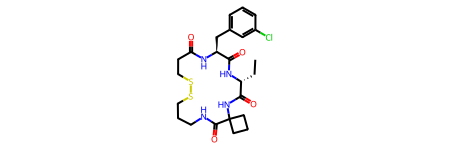

Permeability: -4.5420025237817905


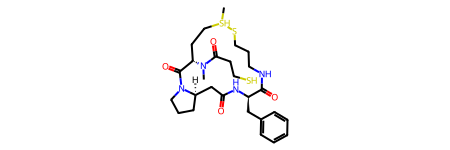

In [5]:
output = main()

In [10]:
output[5]